In [1]:
import os
import os.path as osp
import json
import pickle
import collections as C
import itertools as I
import random
import math
from typing import Dict, List, Union, Tuple

import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

from common.constants import CORE_OPTIONS
from common.utils import remove_comments, normalize_spaces, remove_spaces
from common.pantograph.dataclasses import ProblemGenerationProcess

In [2]:
def is_falsified(d: ProblemGenerationProcess) -> bool:
    if 'eval_old_result' in d.metainfo:
        if any(p is not None for p in d.metainfo['eval_old_result']['falsify_proofs']):
            return True
    assert 'eval_result' in d.metainfo
    # 'eval_result' may contain both falsifying and satisfying
    if any(p is not None for p in d.metainfo['eval_result'].get('satisfy_proofs', [None])):
        return False
    return any(p is not None for p in d.metainfo['eval_result']['falsify_proofs'])

def is_proven(d: ProblemGenerationProcess) -> bool:
    if len(d.trajectory) > 0:
        # Deductive Exploration
        return len(d.formal_statement) > 0 and d.metainfo.get('is_solution_validated')
    else:
        # Baselines
        if len(d.formal_solution_draft or '') > 0:
            return True
        if any(p is not None for p in d.metainfo.get('eval_result', dict()).get('proofs', [None])):
            for p in d.metainfo.get('eval_result', dict()).get('proofs', [None]):
                if p is not None:
                    d.formal_solution_draft = p
            # logger.warning(f"`len(d.formal_solution_draft or '') == 0` but `eval_result` is proven")
            return True
        return False

def is_valid(d: ProblemGenerationProcess) -> bool:
    return is_proven(d) and not is_falsified(d)

def count_prompt_token_cost(d: ProblemGenerationProcess) -> int:
    if len(d.trajectory) > 0:
        # Deductive Exploration
        if 'prompt_tokens' in d.metainfo.keys():
            return d.metainfo['prompt_tokens'] * d.metainfo.get('server_failure_token_discounted_ratio', 1.0)
        else:
            return sum(d.metainfo['token_usage']['prompt_tokens'][d.metainfo.get('first_failure_idx', 0):])
    else:
        # Baselines
        total_prompt_tokens = 0
        if 'token_usage' in d.metainfo and 'generate_statement' in d.metainfo['token_usage']:
            # Whole-statement generation baseline
            assert 'token_usage:stmt_autoformalizer' not in d.metainfo
            assert len(d.metainfo['token_usage']['generate_statement']) == 2
            total_prompt_tokens += d.metainfo['token_usage']['generate_statement'][1]
            if 'provers.prove' in d.metainfo['token_usage']:
                total_prompt_tokens += sum(d.metainfo['token_usage']['provers.prove']['prompt_tokens'])
        elif 'token_usage:stmt_autoformalizer' in d.metainfo:
            # Autoformalization-based baselines
            total_prompt_tokens += sum(d.metainfo['token_usage:stmt_autoformalizer']['prompt_tokens'])
            if 'eval_result' in d.metainfo.keys():
                total_prompt_tokens += sum(d.metainfo['eval_result']['prove_token_usage']['prompt_tokens'])
        else:
            # MUSTARD baseline
            total_prompt_tokens += sum(d.metainfo['eval_result']['prove_token_usage']['prompt_tokens'])
        return total_prompt_tokens

def count_token_cost(d: ProblemGenerationProcess) -> int:
    if len(d.trajectory) > 0:
        # Deductive Exploration
        if 'completion_tokens' in d.metainfo.keys():
            return d.metainfo['completion_tokens'] * d.metainfo.get('server_failure_token_discounted_ratio', 1.0)
        else:
            return sum(d.metainfo['token_usage']['completion_tokens'][d.metainfo.get('first_failure_idx', 0):])
    else:
        # Baselines
        total_completion_tokens = 0
        if 'token_usage' in d.metainfo and 'generate_statement' in d.metainfo['token_usage']:
            # Whole-statement generation baseline
            assert 'token_usage:stmt_autoformalizer' not in d.metainfo
            assert len(d.metainfo['token_usage']['generate_statement']) == 2
            total_completion_tokens += d.metainfo['token_usage']['generate_statement'][0]
            if 'provers.prove' in d.metainfo['token_usage']:
                total_completion_tokens += sum(d.metainfo['token_usage']['provers.prove']['completion_tokens'])
        elif 'token_usage:stmt_autoformalizer' in d.metainfo:
            # Autoformalization-based baselines
            total_completion_tokens += sum(d.metainfo['token_usage:stmt_autoformalizer']['completion_tokens'])
            if 'eval_result' in d.metainfo.keys():
                total_completion_tokens += sum(d.metainfo['eval_result']['prove_token_usage']['completion_tokens'])
        else:
            # MUSTARD baseline
            total_completion_tokens += sum(d.metainfo['eval_result']['prove_token_usage']['completion_tokens'])
        return total_completion_tokens

def count_kc(d: ProblemGenerationProcess) -> int:
    try:
        if 'proving_results' in d.metainfo:
            return len(remove_spaces(remove_comments(d.formal_solution_draft)))
        else:
            return d.metainfo['eval_result']['KC']
    except:
        # return len(remove_spaces(remove_comments(d.formal_solution_draft)))
        return float('nan')

def count_step_kc(d: ProblemGenerationProcess) -> int:
    try:
        return len(remove_spaces(remove_comments(d.formal_solution_draft)))
    except:
        return float('nan')

def count_falsifier_prompt_token_cost(d: ProblemGenerationProcess) -> int:
    try:
        return sum((sum(v) for v in d.metainfo['falsifier_token_usage']['prompt_tokens']))
    except:
        return 0

def count_falsifier_token_cost(d: ProblemGenerationProcess) -> int:
    try:
        return sum((sum(v) for v in d.metainfo['falsifier_token_usage']['completion_tokens']))
    except:
        return 0

In [3]:
output_root = '/home/ma-user/workspace/formal_problem_generation/output_tmp/output'

results_settings = []

# Numina-Lean-reasseblmed.39509.problem_generator
exp_name = 'Our Method'
path_prefix = 'sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_kc.20250913-004304.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'problem_generation.20250909-090734.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# Main (Repeated)
exp_name = 'Our Method (Repeated)'
path_prefix = 'sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250913-220057.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'problem_generation.20250913-124624.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# Ablation (-Order)
exp_name = 'Ablation (Staged)'
path_prefix = 'sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913.staged'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250914-104447.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'staged_problem_generation.20250913-214247.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# Numina-Lean.whole_statement_generatior
exp_name = 'Ablation (Whole-Generation)'
path_prefix = 'sft_wg_starified/Goedel-Prover-V2-8B.Numina-Lean.whole_statement_generatior.nopack'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-162131.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'problem_generation.20250909-232315.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))


# PromptCoT-QwQ_kimina7b
exp_name = 'PromptCoT-QwQ'
path_prefix = 'autoformalization_pg_kimina7b/PromptCoT-QwQ_kimina7b'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154953.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154953.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# PromptCoT-DS_kimina7b
exp_name = 'PromptCoT-DS'
path_prefix = 'autoformalization_pg_kimina7b/PromptCoT-DS_kimina7b'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154956.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154956.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# ScaleQuest-Math_kimina7b
exp_name = 'ScaleQuest-Math'
path_prefix = 'autoformalization_pg_kimina7b/ScaleQuest-Math_kimina7b'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154955.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-154955.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

# MUSTARDSauce_lean4_parsed
exp_name = 'MUSTARD'
path_prefix = 'MUSTARDSauce_lean4_parsed'
load_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-121840.pkl'
)
log_path = osp.join(
    output_root, path_prefix,
    'fpg_evaluate_falsify_prove.20250911-121840.log'
)
results_settings.append((exp_name, path_prefix, load_path, log_path))

In [4]:
exp_results = dict()

for (exp_name, path_prefix, load_path, log_path) in results_settings:
    failure_steps = C.defaultdict(list)
    with open(load_path, 'rb') as f:
        (conditions, finished_list) = pickle.load(f)
    with open(log_path, 'r') as f:
        for l in f.readlines():
            l = l.strip()
            if 'agent.problem_generation:generate_async' in l and l.endswith('failed due to AssertionError()'):
                e = l.split()
                assert e[7].startswith('generate_async(') and e[7].endswith('):')
                gen_idx = int(e[7][len('generate_async('):-len('):')])
                step_idx = int(e[8].split('/')[0])
                failure_steps[gen_idx].append(step_idx)

    for d in finished_list:
        try:
            d.metainfo = json.loads(d.metainfo)
        except:
            pass

    if exp_name == 'MUSTARD':
        conditions, finished_list = [c for (c, d) in zip(conditions, finished_list) if 'eval_result' in d.metainfo.keys()], [d for (c, d) in zip(conditions, finished_list) if 'eval_result' in d.metainfo.keys()]

    print(exp_name, path_prefix, len(conditions), len(finished_list), len(failure_steps))

    for (gen_idx, step_idx_list) in failure_steps.items():
        if step_idx_list == list(range(step_idx_list[0], 81)):
            # print(f'True, {gen_idx}')
            assert len(finished_list[gen_idx].steps) < step_idx_list[0]
            finished_list[gen_idx].metainfo['server_failure_token_discounted_ratio'] = (1 - len(step_idx_list) / 80)
            finished_list[gen_idx].metainfo['first_failure_idx'] = step_idx_list[0] - 1
            # print(len(step_idx_list) / 80)
        else:
            print(f'False, {gen_idx}, {len(set(range(step_idx_list[0], 81))-set(step_idx_list))}')
    
    exp_results[exp_name] = finished_list

Our Method sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch 5000 5000 517
False, 215, 30
False, 783, 21
False, 1202, 60
False, 1802, 31
False, 2374, 2
False, 2548, 43
False, 3183, 7
False, 3564, 2
False, 4264, 27
Our Method (Repeated) sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913 5000 5000 0
Ablation (Staged) sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913.staged 5000 5000 0
Ablation (Whole-Generation) sft_wg_starified/Goedel-Prover-V2-8B.Numina-Lean.whole_statement_generatior.nopack 5000 5000 0
PromptCoT-QwQ autoformalization_pg_kimina7b/PromptCoT-QwQ_kimina7b 5000 5000 0
PromptCoT-DS autoformalization_pg_kimina7b/PromptCoT-DS_kimina7b 5000 5000 0
ScaleQuest-Math autoformalization_pg_kimina7b/ScaleQuest-Math_kimina7b 5000 5000 0
MUSTARD MUSTARDSauce_lean4_parsed 3794 3794 0


In [ ]:
print(
    'Method', '#All', '#Submitted', '#Proven', '#Falsified', '#Valid',
    'Prompt Token Cost', 'Token Cost',
    'Falsifier Prompt Token Cost', 'Falsifier Token Cost',
    'Complexity (Proof)', 'Complexity (Gen)',
    'Top-1000 Complexity (Proof)', 'Top-1000 Complexity (Gen)',
    '#Inf',
    sep='\t')
for (exp_name, finished_list) in exp_results.items():
    submitted_list = [d for d in finished_list if len(d.formal_statement or '') > 0]
    falsified_list = [d for d in submitted_list if is_falsified(d)]
    proven_list = [d for d in submitted_list if is_proven(d)]
    valid_list = [d for d in submitted_list if is_valid(d)]
    prompt_token_cost_list = [count_prompt_token_cost(d) for d in finished_list]
    token_cost_list = [count_token_cost(d) for d in finished_list]
    falsifier_prompt_token_cost_list = [count_falsifier_prompt_token_cost(d) for d in finished_list]
    falsifier_token_cost_list = [count_falsifier_token_cost(d) for d in finished_list]
    kc_list = [count_kc(d) for d in valid_list]
    n_inf = len([kc for kc in kc_list if kc == float('inf')])
    finite_kc_list = sorted([kc for kc in kc_list if kc != float('inf')])
    step_kc_list = sorted([count_step_kc(d) for d in valid_list])


    print(exp_name,
        len(finished_list), len(submitted_list), len(proven_list), len(falsified_list), len(valid_list),
        sum(prompt_token_cost_list)/len(valid_list), sum(token_cost_list)/len(valid_list),
        sum(falsifier_prompt_token_cost_list)/len(valid_list), sum(falsifier_token_cost_list)/len(valid_list),
        sum(finite_kc_list)/len(finite_kc_list), sum(step_kc_list)/len(step_kc_list),
        sum(finite_kc_list[-1000:])/len(finite_kc_list[-1000:]), sum(step_kc_list[-1000:])/len(step_kc_list[-1000:]),
        n_inf,
        sep='\t')

Method	#All	#Submitted	#Proven	#Falsified	#Valid	Prompt Token Cost	Token Cost	Falsifier Prompt Token Cost	Falsifier Prompt Token Cost	Complexity (Proof)	Complexity (Gen)	Top-1000 Complexity (Proof)	Top-1000 Complexity (Gen)	#Inf
Our Method	5000	3314	3209	497	2726	29726.34140223773	8841.159102164343	0.0	0.0	515.241935483871	397.7314746881878	1004.975	814.614	60
Our Method (Repeated)	5000	3282	3192	473	2734	29280.7852962692	8345.89209948793	2926.2205559619606	7115.684345281638	505.3155737704918	376.2311631309437	986.741	772.472	50
Ablation (Staged)	5000	2683	2605	269	2340	34868.85213675214	8800.142735042735	1850.8867521367522	4953.513247863248	470.2117903930131	346.2846153846154	853.793	659.194	50
Ablation (Whole-Generation)	5000	4377	1589	1817	1164	7317.507731958763	187127.85137457045	0.0	0.0	578.4699312714777	578.4699312714777	667.632	667.632	0
PromptCoT-QwQ	5000	3471	1189	729	1024	7747.4716796875	172926.85546875	0.0	0.0	720.76171875	720.76171875	737.883	737.883	0
PromptCoT-DS	5000	323

In [6]:
raise

RuntimeError: No active exception to reraise

## Visualization

In [5]:
kc_dict = {
    k : [count_kc(d) for d in ds if (len(d.formal_statement or '') > 0) and is_valid(d)] for (k, ds) in exp_results.items()
}

In [6]:
for k, l in kc_dict.items():
    print(k, sorted(l))

sft_wg_starified/Goedel-Prover-V2-8B.Numina-Lean.whole_statement_generatior.nopack [3, 3, 4, 4, 4, 4, 4, 5, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 16, 17, 18, 19, 19, 20, 21, 21, 22, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 34, 36, 36, 37, 37, 37, 37, 37, 37, 37, 38, 38, 40, 43, 43, 43, 43, 44, 45, 45, 45, 45, 45, 45, 46, 46, 47, 48, 49, 49, 49, 50, 51, 52, 53, 53, 55, 56, 56, 57, 58, 58, 60, 60, 62, 62, 63, 63, 63, 64, 64, 65, 65, 65, 65, 65, 70, 70, 70, 71, 71, 72, 73, 73, 74, 74, 74, 75, 75, 76, 77, 78, 78, 78, 78, 79, 80, 81, 81, 82, 84, 84, 84, 85, 85, 86, 86, 87, 88, 90, 90, 90, 90, 91, 91, 91, 92, 92, 93, 94, 94, 94, 95, 95, 95, 95, 95, 96, 98, 100, 100, 101, 101, 101, 101, 102, 103, 103, 105, 105, 105, 106, 106, 106, 106, 106, 106, 107, 108, 108, 110, 111, 112, 112, 113, 113, 113, 113, 114, 116, 117, 117

In [7]:
kc_dict.pop('sft_ar_v3/Goedel-Prover-V2-8B.Numina-Lean-linear.39980.problem_generator.nopack')
kc_dict.pop('sft_ar_v2_strict/Goedel-Prover-V2-8B.Numina-Lean.problem_generator.nopack')

[272,
 3,
 525,
 474,
 138,
 721,
 159,
 139,
 600,
 395,
 93,
 129,
 483,
 543,
 966,
 122,
 15,
 335,
 409,
 8,
 223,
 1504,
 673,
 287,
 279,
 11,
 724,
 464,
 5,
 inf,
 748,
 59,
 607,
 353,
 42,
 393,
 inf,
 382,
 600,
 175,
 575,
 888,
 56,
 112,
 554,
 481,
 922,
 370,
 1187,
 8,
 71,
 565,
 273,
 228,
 2173,
 878,
 485,
 120,
 306,
 697,
 560,
 219,
 278,
 699,
 181,
 452,
 629,
 496,
 946,
 1273,
 29,
 394,
 405,
 342,
 456,
 493,
 165,
 957,
 97,
 17,
 386,
 858,
 1086,
 99,
 182,
 87,
 129,
 506,
 16,
 47,
 238,
 913,
 174,
 555,
 inf,
 225,
 891,
 299,
 498,
 72,
 17,
 909,
 207,
 53,
 391,
 87,
 339,
 96,
 232,
 486,
 811,
 133,
 371,
 1015,
 527,
 130,
 1052,
 165,
 120,
 603,
 1639,
 469,
 560,
 1351,
 346,
 1477,
 698,
 99,
 592,
 885,
 24,
 231,
 517,
 1227,
 182,
 1255,
 130,
 1284,
 249,
 951,
 89,
 100,
 1117,
 689,
 110,
 1996,
 815,
 557,
 155,
 708,
 1643,
 5,
 221,
 508,
 585,
 377,
 134,
 54,
 506,
 716,
 82,
 356,
 1305,
 719,
 249,
 37,
 419,
 686,
 397,
 542

In [8]:
def create_custom_bins() -> Tuple[List[float], List[str], List[float]]:
    """创建自定义的 bins：0~100, 100~200...900~1000, 1000~2000, 2000~4000, 4000+, inf"""
    # 生成 0-1000 之间每100为间隔的bin
    bins = list(range(0, 1100, 100))  # [0, 100, 200, ..., 1000]
    
    # 添加 1000-2000, 2000-4000
    bins.extend([2000, 4000])
    
    # 添加 4000+ 和 inf 作为最后两个区间
    bins.append(float('inf') - 1)  # 用于表示4000+区间的上限
    bins.append(float('inf'))
    
    # 创建 bins 标签
    bin_labels = []
    # 0-1000的标签
    for i in range(10):
        bin_labels.append(f"{i*100}~{(i+1)*100}")
    
    # 添加其他区间标签
    bin_labels.extend(["1000~2000", "2000~4000", "4000+", "inf"])
    
    # 计算每个bin的中心（用于曲线绘制）
    bin_centers = []
    # 0-1000区间的中心
    for i in range(10):
        bin_centers.append(i*100 + 50)
    
    # 其他区间的中心
    bin_centers.extend([1500, 3000, 5000, 6000])  # 4000+使用5000作为中心，inf使用6000
    
    return bins, bin_labels, bin_centers

def calculate_frequency(data: List[float], bins: List[float]) -> List[int]:
    """计算数据在每个 bin 中的频数"""
    frequencies = [0] * (len(bins) - 1)
    
    for value in data:
        # 处理inf的特殊情况
        if math.isinf(value):
            frequencies[-1] += 1
            continue
            
        # 查找对应的区间
        for i in range(len(bins) - 1):
            if bins[i] <= value < bins[i+1]:
                frequencies[i] += 1
                break
        else:
            # 如果没有找到合适的bin（理论上不会发生）
            pass
    
    return frequencies

# def smooth_curve(x: List[float], y: List[int], num_points: int = 100) -> Tuple[np.ndarray, np.ndarray]:
#     """对曲线进行平滑处理"""
#     # 排除inf对应的点进行插值
#     finite_mask = np.isfinite(x)
#     x_finite = np.array(x)[finite_mask]
#     y_finite = np.array(y)[finite_mask]
    
#     if len(x_finite) < 2:  # 数据点太少无法平滑
#         return np.array(x), np.array(y)
    
#     # 创建插值函数
#     spl = make_interp_spline(x_finite, y_finite, k=min(3, len(x_finite)-1))  # 三次样条或更低阶
    
#     # 生成更密集的x值
#     x_smooth = np.linspace(min(x_finite), max(x_finite), num_points)
#     y_smooth = spl(x_smooth)
    
#     return x_smooth, y_smooth

def plot_experiment_comparison(experiments: Dict[str, List[float]], 
                              figsize: Tuple[int, int] = (14, 8), smooth_points: int = 100) -> plt.Figure:
    """绘制多组实验结果的频数分布对比图，使用自定义区间划分"""
    # 创建自定义的 bins
    bins, bin_labels, bin_centers = create_custom_bins()
    
    # 计算每组实验的频数
    experiment_freqs = {}
    for exp_name, exp_data in experiments.items():
        experiment_freqs[exp_name] = calculate_frequency(exp_data, bins)
    
    # 设置图形
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=figsize)
    
    # 设置柱状图位置
    bar_width = 0.8 / len(experiments)
    indices = np.arange(len(bin_labels))
    
    # 绘制每组实验的柱状图和曲线
    for i, (exp_name, frequencies) in enumerate(experiment_freqs.items()):
        # 绘制柱状图
        bars = ax.bar(indices + i * bar_width, frequencies, bar_width, 
                      label=exp_name, alpha=0.7)
        
        # 绘制频率曲线（使用bin中心作为x值）
        # x_smooth, y_smooth = smooth_curve(bin_centers, frequencies, smooth_points)
        
        # 曲线使用与柱状图相同的颜色
        color = bars[0].get_facecolor()
        # ax.plot(x_smooth, y_smooth, color=color, linewidth=2, linestyle='-')
    
    # 设置图表属性
    ax.set_xlabel('Complexity Range', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Distribution', fontsize=14, pad=20)
    ax.set_xticks(indices + bar_width * (len(experiments) - 1) / 2)
    ax.set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=10)
    
    # 添加网格线使读数更方便
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 调整布局
    plt.tight_layout()
    
    return fig


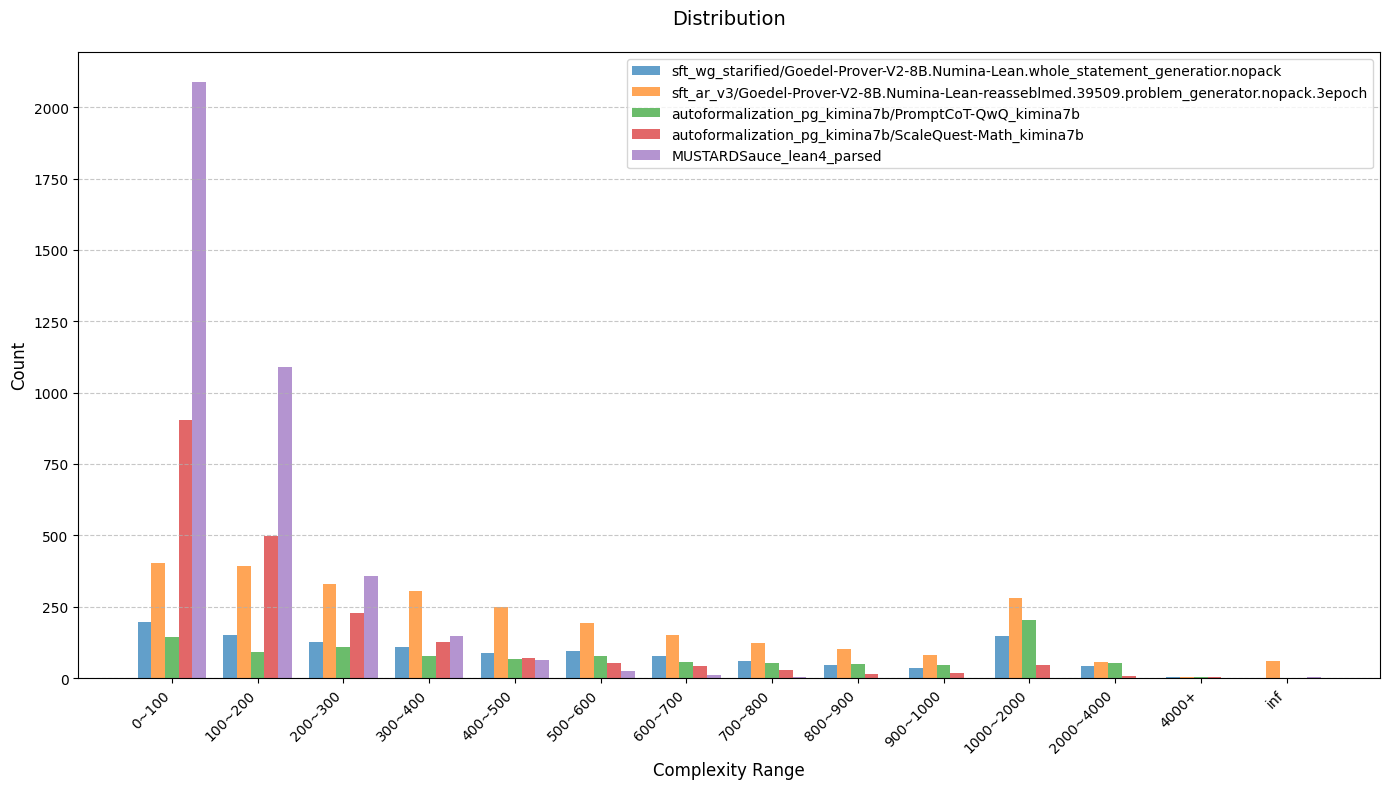

In [9]:
fig = plot_experiment_comparison(kc_dict)
plt.show()

In [10]:
def visualize_experiments_with_inf(results: Dict[str, List[float]], 
                                  title: str = "Distribution",
                                  figsize: tuple = (24, 16),
                                  showfliers: bool = False):
    """
    可视化对比多组实验结果，重点突出显示inf值
    
    参数:
        results: 实验结果字典，key为实验名称，value为结果列表
        title: 图表标题
        figsize: 图表尺寸
        showfliers: 是否显示离群值（非inf的异常值）
    """
    # 基础配置：解决中文显示和负号问题
    # plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
    plt.rcParams["axes.unicode_minus"] = False
    plt.rcParams["font.size"] = 5  # 基础字体大小，提升可读性

    # 提取实验名称和原始数据
    exp_names = list(results.keys())
    raw_data = list(results.values())
    num_exps = len(exp_names)

    # --------------------------
    # 1. 数据预处理：分离有限值和inf，计算关键参数
    # --------------------------
    processed_data = []  # 处理后的数据（inf替换为合理值用于箱线图范围）
    inf_counts = []      # 每组的inf数量
    max_finite_per_exp = []  # 每组有限值的最大值（用于定位inf标记）

    for data in raw_data:
        # 分离有限值和inf
        finite_vals = [x for x in data if not math.isinf(x)]
        inf_count = len(data) - len(finite_vals)
        inf_counts.append(inf_count)

        # 计算每组有限值的最大值（用于后续处理）
        if finite_vals:
            max_finite = max(finite_vals)
            max_finite_per_exp.append(max_finite)
            # 替换inf：用“有限值最大值的1.1倍”作为占位（不影响箱线图，仅用于y轴范围）
            processed = [x if not math.isinf(x) else max_finite * 1.1 for x in data]
        else:
            # 极端情况：全为inf时，用10000作为基础占位（可根据实际数据调整）
            max_finite_per_exp.append(10000)
            processed = [10000 * 1.1]  # 单个占位值，避免箱线图报错
        processed_data.append(processed)

    # 计算全局y轴上限：确保能容纳所有数据+inf标记（留10%余量）
    global_max = max([max(data) for data in processed_data])
    y_upper = global_max * 1.1

    # --------------------------
    # 2. 创建图表并绘制箱线图
    # --------------------------
    fig, ax = plt.subplots(figsize=figsize)

    # 绘制箱线图：用不同颜色区分实验组，增强辨识度
    box_plot = ax.boxplot(
        processed_data,
        patch_artist=True,  # 允许填充箱体颜色
        showfliers=showfliers,
        positions=range(1, num_exps + 1),  # 箱体位置（1,2,3...）
        widths=0.6  # 箱体宽度，避免过宽或过窄
    )

    # 美化箱体：使用渐变色系（Set3），每组颜色不同
    colors = plt.cm.Set3(np.linspace(0, 1, num_exps))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)  # 轻微透明，避免过于刺眼

    # --------------------------
    # 3. 突出标记inf值：红色星号+数量标注
    # --------------------------
    inf_marker_size = 80  # inf标记大小
    inf_label_added = False  # 控制图例只添加一次

    for i in range(num_exps):
        exp_idx = i + 1  # 对应箱线图的x轴位置（1-based）
        inf_count = inf_counts[i]
        max_finite = max_finite_per_exp[i]

        if inf_count > 0:
            # 3.1 绘制inf标记：红色星号（*），位于每组箱体上方
            # y坐标：有限值最大值的1.05倍（确保在箱线图上限之上，不重叠）
            inf_y = max_finite * 1.05
            marker = ax.scatter(
                x=exp_idx,
                y=inf_y,
                s=inf_marker_size,
                c='red',
                marker='*',
                label='Inf position' if not inf_label_added else "",
                zorder=5  # 提高层级，确保标记在箱线图之上
            )
            inf_label_added = True

            # 3.2 标注inf数量：在星号右侧，红色文字
            ax.text(
                x=exp_idx + 0.1,  # 向右偏移0.1，避免与星号重叠
                y=inf_y,
                s=f'×{inf_count}',  # 格式：×2（表示2个inf）
                c='darkred',
                fontweight='bold',
                fontsize=10,
                verticalalignment='center'  # 垂直居中对齐
            )

    # --------------------------
    # 4. 图表细节优化：标题、标签、网格等
    # --------------------------
    # 标题和轴标签
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Experiment Group', fontsize=14, labelpad=15)
    ax.set_ylabel('Experinment results', fontsize=14, labelpad=15)

    # x轴：替换为实验名称，旋转45度避免重叠
    ax.set_xticks(range(1, num_exps + 1))
    ax.set_xticklabels(exp_names, rotation=45, ha='right')  # ha='right'：标签右对齐

    # y轴：设置范围，确保底部从0开始（符合实验结果的非负性）
    ax.set_ylim(bottom=0, top=y_upper)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))  # 千分位分隔符

    # 网格线：仅y轴显示虚线网格，辅助读数
    ax.yaxis.grid(True, linestyle='--', alpha=0.5, color='gray')
    ax.set_axisbelow(True)  # 网格线在图层下方，不遮挡数据

    # 图例：包含inf标记说明
    if inf_label_added:
        ax.legend(loc='upper left', framealpha=0.9, edgecolor='black')

    # 调整布局：避免标签被截断
    plt.tight_layout()

    return fig


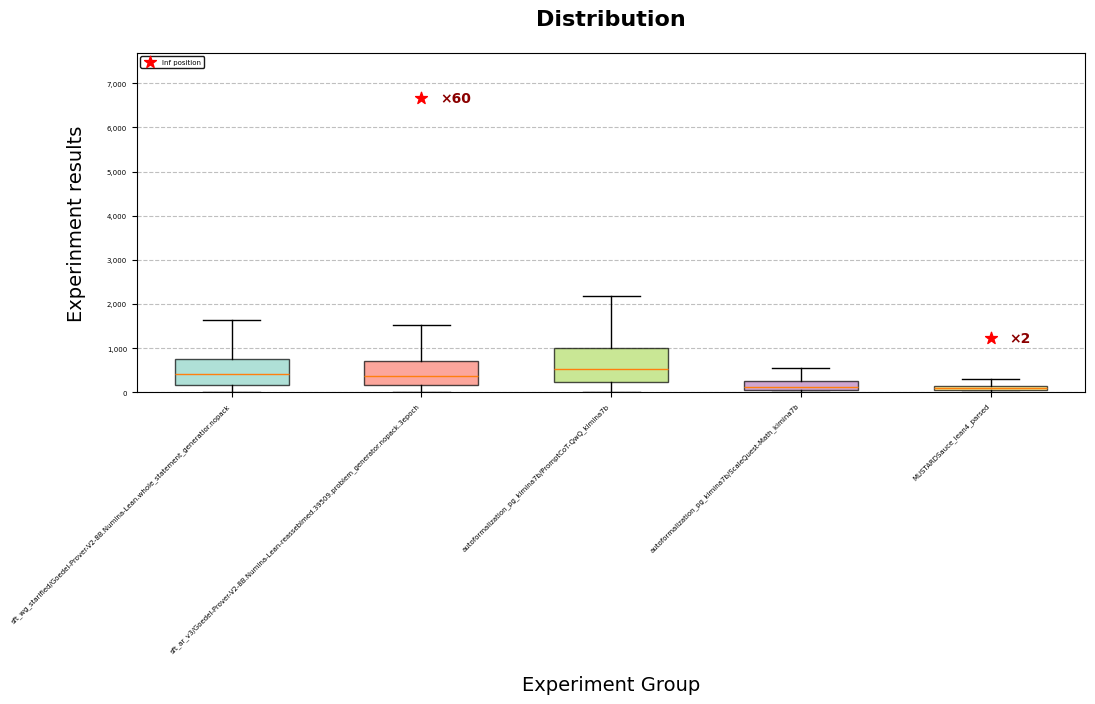

In [11]:
fig = visualize_experiments_with_inf(
    results=kc_dict,
    title="Distribution",
    figsize=(11, 7)
)

# 3. 显示图表（若需保存，取消下方注释）
plt.show()